# Need to install an additional package

`conda install executorlib`

## Download AqSolDb v1 the first time you run:

In [2]:
# !curl https://www.amdlab.nl/database/AqSolDB/data/AqSolDB_v1.0_min.csv > AqSolDB_v1.0_min.csv

In [1]:
import pandas as pd
from tqdm import tqdm
from architector.io_obabel import get_obmol_smiles, get_OBMol_coords_anums_graph
import architector.io_ptable as io_ptable
from architector import convert_io_molecule, view_structures
from architector.io_obabel import generate_obmol_conformers
from executorlib import Executor
import numpy as np

In [2]:
df = pd.read_csv('AqSolDB_v1.0_min.csv')

In [3]:
df

,ID,Name,InChIKey,SMILES,Solubility
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127
1,A-4,Benzo[cd]indol-2(1H)-one,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767
2,A-5,4-chlorobenzaldehyde,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065
...,...,...,...,...,...
9977,I-84,tetracaine,GKCBAIGFKIBETG-UHFFFAOYSA-N,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000
9978,I-85,tetracycline,OFVLGDICTFRJMM-WESIUVDSSA-N,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000
9979,I-86,thymol,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000
9980,I-93,verapamil,SGTNSNPWRIOYBX-UHFFFAOYSA-N,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000


In [4]:
f1 = (df.SMILES.str.count('\.') < 1) # Remove any disjoint components

In [5]:
f2 = pd.Series([True]*df.shape[0])
natoms = pd.Series([0.0]*df.shape[0])
for i,row in tqdm(df.iterrows(), total=df.shape[0]):
    obmol = get_obmol_smiles(row['SMILES'], build=False)
    _ , syms, _  = get_OBMol_coords_anums_graph(obmol, get_types=True)
    natoms.loc[i] = len(syms)
    mets = [x for x in syms if x in io_ptable.all_metals]
    if len(mets) > 0:
        f2[i] = False

100%|████████████████████████████████████████████████████████████████| 9982/9982 [00:09<00:00, 1096.15it/s]


In [6]:
df['natoms'] = natoms

In [11]:
f3 = df.natoms < 400 # Size limit - only 1 larger

In [12]:
fdf = df[(f2) & (f1) & (f3)]
print(fdf.shape)

(8796, 6)


In [13]:
fdf.SMILES.value_counts()

SMILES
CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O                                                      1
O=C1Nc2cccc3cccc1c23                                                                       1
Clc1ccc(C=O)cc1                                                                            1
C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO6)cc3                                        1
Cc1cccc(C=C)c1                                                                             1
                                                                                          ..
OC(=O)C1CCCCC1                                                                             1
C(CCCN=C\C=C\c1ccccc1)CCN=C/C=C/c2ccccc2                                                   1
CC(C)(C)CC(C)(C)c1cc(Cc2cc(cc(n3nc4ccccc4n3)c2O)C(C)(C)CC(C)(C)C)c(O)c(c1)n5nc6ccccc6n5    1
C1CN(CCO1)Sc2sc3ccccc3n2                                                                   1
CC1(C)[C@H]2C[C@@H]3O[C@]3(C)[C@@H]1C2                         

<Axes: >

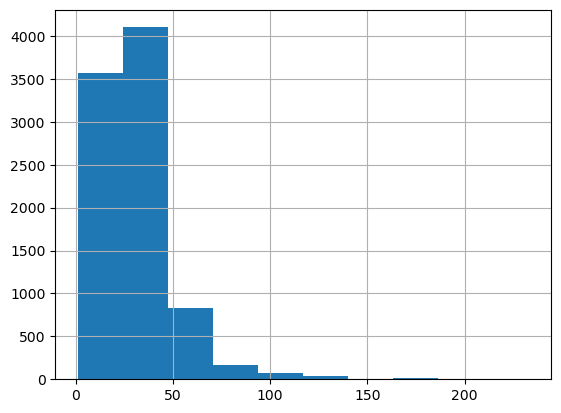

In [14]:
fdf.natoms.hist()

In [15]:
fdf.to_csv('filtered_aq_soldb.csv')

In [16]:
def gen_confs(smi, totaln=50):
    inmol = convert_io_molecule(smi)
    confs, energies = generate_obmol_conformers(inmol, return_energies=True, conf_cutoff=totaln*100)
    energies = np.array(energies)
    confs = np.array(confs)
    inds = np.argsort(energies)[0:totaln]
    energies = energies[inds]
    confs = confs[inds]
    out_confs = []
    for i,conf in enumerate(confs):
        tmol = convert_io_molecule(conf)
        tmol.charge = inmol.charge
        tmol.uhf = 0
        tmol.xtb_charge = inmol.charge
        tmol.xtb_uhf = 0
        tconf = tmol.write_mol2('UFF_Energy={}'.format(energies[i]), writestring=True)
        out_confs.append(tconf)
    return out_confs

In [17]:
fdf[fdf.natoms > 100].SMILES.values[1]

'CO[C@H]1C[C@@H](O[C@@H](C)[C@@H]1O)OC2[C@H](C)O[C@H](C[C@@H]2OC)OC3[C@@H](C)/C=C/C=C/4CO[C@@H]5[C@H](O)C(=C[C@@H](C(=O)O[C@H]6C[C@@H](C\\C=C3/C)O[C@@]7(C6)O[C@@H]([C@@H](C)C=C7)C8CCCCC8)[C@]45O)C'

In [18]:
confs = gen_confs('[O-]CCCCC')
#confs = gen_confs(fdf[fdf.natoms > 100].SMILES.values[1])

In [19]:
confs

['@<TRIPOS>MOLECULE\nUFF_Energy=0.18325400322895535 Charge: -1 Unpaired_Electrons: 0 XTB_Unpaired_Electrons: 0 XTB_Charge: -1\n    17    16     1     0     0\nSMALL\nNoCharges\n****\nGenerated from Architector\n\n@<TRIPOS>ATOM\n     1 O1        2.5614   -0.4492    2.6016   O.3       1 RES1   0.0000\n     2 C1        2.1702   -1.4784    1.8678   C.3       1 RES1   0.0000\n     3 C2        2.7027   -1.2748    0.4234   C.3       1 RES1   0.0000\n     4 C3        2.3497   -2.3768   -0.5923   C.3       1 RES1   0.0000\n     5 C4        2.8826   -2.1597   -2.0105   C.3       1 RES1   0.0000\n     6 C5        2.5068   -3.2752   -2.9740   C.3       1 RES1   0.0000\n     7 H1        2.4765   -2.4919    2.1697   H         1 RES1   0.0000\n     8 H2        1.0859   -1.6255    1.7400   H         1 RES1   0.0000\n     9 H3        2.3124   -0.3194    0.0493   H         1 RES1   0.0000\n    10 H4        3.7959   -1.1530    0.4376   H         1 RES1   0.0000\n    11 H5        2.7359   -3.3300   -0.210

In [20]:
view_structures(confs[0:10])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [21]:
len(confs)

25

In [12]:
print(confs[0])

@<TRIPOS>MOLECULE
UFF_Energy=0.18387233505621525 Charge: -1 Unpaired_Electrons: 0 XTB_Unpaired_Electrons: 0 XTB_Charge: -1
    17    16     1     0     0
SMALL
NoCharges
****
Generated from Architector

@<TRIPOS>ATOM
     1 O1        2.5957    2.3900    1.1867   O.3       1 RES1   0.0000
     2 C1        2.2034    1.4242    2.0047   C.3       1 RES1   0.0000
     3 C2        2.7363    0.0752    1.4492   C.3       1 RES1   0.0000
     4 C3        2.3843   -1.1815    2.2648   C.3       1 RES1   0.0000
     5 C4        2.9167   -2.5023    1.7041   C.3       1 RES1   0.0000
     6 C5        2.5410   -3.7117    2.5470   C.3       1 RES1   0.0000
     7 H1        2.5089    1.4664    3.0600   H         1 RES1   0.0000
     8 H2        1.1186    1.2647    2.1157   H         1 RES1   0.0000
     9 H3        2.3437   -0.0502    0.4308   H         1 RES1   0.0000
    10 H4        3.8288    0.1191    1.3326   H         1 RES1   0.0000
    11 H5        2.7709   -1.0483    3.2831   H         1 RES1 

In [22]:
ind = 12
confs = gen_confs(fdf.iloc[ind]['SMILES'])
print('Confomers:', len(confs))
view_structures(fdf.iloc[ind]['SMILES'])
view_structures(confs[0:4])

Confomers: 50


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [23]:
def evalulate_conf_xtb(conf):
    import os
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
    os.environ["NUMEXPR_NUM_THREADS"] = "1"
    from architector.io_calc import CalcExecutor
    from xtb_solvent import xtb_solv_params
    solvent='water'
    out = CalcExecutor(conf,
                       method='GFN2-xTB',
                       store_results=True,
                       relax=True,
                       fmax=0.05,
                       xtb_solvent=solvent)
    if out.successful:
        results = out.results
        results['xtb_mol2'] = out.mol.write_mol2('GFn2-XTB_relax', 
                                                  writestring=True)
        xtb_sa_eval_dict = xtb_solv_params(results['xtb_mol2'], solvent=solvent)
        if isinstance(xtb_sa_eval_dict, dict):
            results.update(xtb_sa_eval_dict)
        else:
            return None
        return results
    else:
        return None

In [24]:
out = evalulate_conf_xtb(confs[0])

In [25]:
out.keys()

dict_keys(['energy', 'free_energy', 'forces', 'dipole', 'charges', 'xtb_mol2', 'sas', 'born_radii'])

In [26]:
with Executor(max_workers=12, cores_per_worker=1, threads_per_core=1,
              hostname_localhost=True,# Needed on Mac only
              block_allocation=True) as exe:
    out_results = list(tqdm(exe.map(evalulate_conf_xtb, confs), total=len(confs)))

100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.08it/s]


In [27]:
def full_conf_xtb_workflow(insmiles):
    import os
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
    os.environ["NUMEXPR_NUM_THREADS"] = "1"
    from architector.io_calc import CalcExecutor
    from architector import convert_io_molecule
    from architector.io_obabel import generate_obmol_conformers
    from xtb_solvent import xtb_solv_params
    solvent = 'water'
    totaln = 50
    def gen_confs(smi):
        inmol = convert_io_molecule(smi)
        confs, energies = generate_obmol_conformers(inmol,
                                                    return_energies=True,
                                                    conf_cutoff=totaln*100)
        energies = np.array(energies)
        confs = np.array(confs)
        inds = np.argsort(energies)[0:totaln]
        energies = energies[inds]
        confs = confs[inds]
        out_confs = []
        for i,conf in enumerate(confs):
            tmol = convert_io_molecule(conf)
            tmol.charge = inmol.charge
            tmol.uhf = 0
            tmol.xtb_charge = inmol.charge
            tmol.xtb_uhf = 0
            tconf = tmol.write_mol2('UFF_Energy={}'.format(energies[i]), writestring=True)
            out_confs.append(tconf)
        return out_confs
    confs = gen_confs(insmiles)
    results_list = []
    for conf in confs:
        try:
            out = CalcExecutor(conf,
                               method='GFN2-xTB',
                               store_results=True,
                               relax=True,
                               fmax=0.05,
                               xtb_solvent=solvent)
            if out.successful:
                results = out.results
                results['xtb_mol2'] = out.mol.write_mol2('GFn2-XTB_relax', 
                                                         writestring=True)
                results['uff_energy'] = float(conf.split('\n')[1].split('=')[1].split()[0])
                results['uff_mol2'] = conf
                results['smiles'] = insmiles
                results['total_charge'] = out.mol.charge
                results['total_unpaired_electrons'] = out.mol.uhf
                results['n_atoms'] = len(out.mol.ase_atoms)
                results['xtb_solvent'] = solvent
                xtb_sa_eval_dict = xtb_solv_params(results['xtb_mol2'],
                                                   solvent=solvent)
                if isinstance(xtb_sa_eval_dict, dict):
                    results.update(xtb_sa_eval_dict)
                    results['error'] = ''
                    results_list.append(results)
                else:
                    results.update({'sas':None, 'born_radii':None,
                                    'error':'XTB Sovlent Eval Error'})
                    results_list.append(results)
            else:
                results = dict()
                results['energy'] = None
                results['free_energy'] = None
                results['forces'] = None
                results['dipole'] = None
                results['charges'] = None
                results['xtb_mol'] = None
                results['uff_energy'] = float(conf.split('\n')[1].split('=')[1].split()[0])
                results['uff_mol2'] = conf
                results['smiles'] = insmiles
                results['total_charge'] = None
                results['total_unpaired_electrons'] = None
                results['n_atoms'] = None
                results['xtb_solvent'] = solvent
                results['sas'] = None
                results['born_radii'] = None
                results['error'] = 'XTB-Python Relaxation Failed'
                results_list.append(results)
        except:
            results = dict()
            results['energy'] = None
            results['free_energy'] = None
            results['forces'] = None
            results['dipole'] = None
            results['charges'] = None
            results['xtb_mol'] = None
            results['uff_energy'] = float(conf.split('\n')[1].split('=')[1].split()[0])
            results['uff_mol2'] = conf
            results['smiles'] = insmiles
            results['total_charge'] = None
            results['total_unpaired_electrons'] = None
            results['n_atoms'] = None
            results['xtb_solvent'] = solvent
            results['sas'] = None
            results['born_radii'] = None
            results['error'] = 'python/XTB error'
            results_list.append(results)
    return results_list

In [ ]:
things = full_conf_xtb_workflow('[O-]CCCCCC')

In [ ]:
outdf = pd.DataFrame(things)
outdf.plot.scatter('uff_energy',
                   'energy')

In [ ]:
smiles_lst = fdf.SMILES.unique()[0:12]
with Executor(max_workers=12, cores_per_worker=1, threads_per_core=1,
              hostname_localhost=True,# Needed on Mac only
                block_allocation=True) as exe:
    out_results = list(tqdm(exe.map(full_conf_xtb_workflow, smiles_lst), total=len(smiles_lst)))

In [ ]:
combined_df = pd.concat([pd.DataFrame(x) for x in out_results])

In [ ]:
combined_df

In [ ]:
df = pd.DataFrame(out_results)

In [ ]:
df

In [ ]:
combined_df